# IEEE Project - Modeling Disease Outbreak
Simulating the spread of a disease between children and teachers in a primary school using the SIR model.

## Importing Libraries

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
from google.colab import files
import missingno as msno
import random
import matplotlib.pyplot as plt
import numpy as np

## Getting the Dataset

In [ ]:
files.upload()

In [3]:
metadata = pd.read_csv('metadata_primaryschool.csv', sep='\t', lineterminator='\n', names=['ID', 'Class', 'Sex'])
contact_network = pd.read_csv('primaryschool.csv', sep='\t', lineterminator='\n', names=['Time', 'ID 1', 'ID 2', 'Class 1', 'Class 2']).sort_values(by=['Time'])

### Metadata

In [4]:
metadata.head()

,ID,Class,Sex
0,1426,5B,M
1,1427,5B,F
2,1428,5B,M
3,1429,5B,F
4,1430,5B,M


In [5]:
N = metadata.shape[0]
print(f"There are {N} people in the model")

There are 242 people in the model


### Contact Network

In [6]:
contact_network.head()

,Time,ID 1,ID 2,Class 1,Class 2
0,31220,1558,1567,3B,3B
1,31220,1560,1570,3B,3B
2,31220,1567,1574,3B,3B
3,31220,1632,1818,4B,4B
4,31220,1632,1866,4B,4B


In [7]:
contact_network.nunique()

Time       3100
ID 1        239
ID 2        241
Class 1      11
Class 2      11
dtype: int64

In [8]:
contact_network.describe()

,Time,ID 1,ID 2
count,125773.000000,125773.000000,125773.000000
mean,90687.675574,1635.858109,1737.303897
std,43793.491033,122.818086,137.779067
min,31220.000000,1426.000000,1427.000000
25%,45640.000000,1545.000000,1653.000000
50%,118580.000000,1661.000000,1759.000000
75%,132020.000000,1719.000000,1857.000000
max,148120.000000,1920.000000,1922.000000


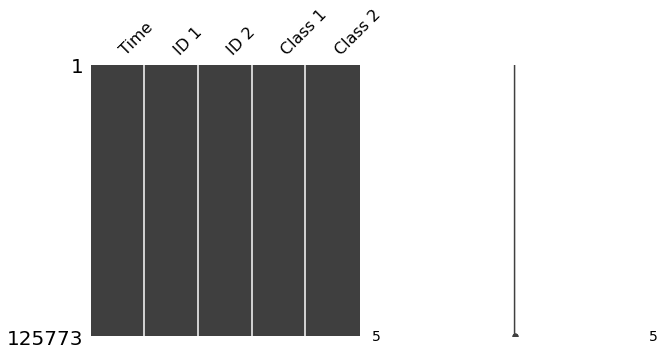

In [9]:
msno.matrix(contact_network, width_ratios=(3, 3), figsize=(10, 5))

We can see that the data is complete. We're gonna use this temporal network of contacts to simulate our SIR model. Each of these contacts is active from t - 20 to t seconds. But since we need to trace the spread over a month, we'll assume the timestep to be 10 minutes long instead of 20 seconds. Using the metadata that we have, we may be able to come up with some interesting statistics as well.

In [10]:
# Adjusting the time column
contact_network['Time'] = contact_network['Time'] - 31220
contact_network['Time'] = contact_network['Time'] // 20
contact_network['Time'] = contact_network['Time'] + 1

contact_network.head()

,Time,ID 1,ID 2,Class 1,Class 2
0,1,1558,1567,3B,3B
1,1,1560,1570,3B,3B
2,1,1567,1574,3B,3B
3,1,1632,1818,4B,4B
4,1,1632,1866,4B,4B


In [11]:
contact_network.describe()

,Time,ID 1,ID 2
count,125773.000000,125773.000000,125773.000000
mean,2974.383779,1635.858109,1737.303897
std,2189.674552,122.818086,137.779067
min,1.000000,1426.000000,1427.000000
25%,722.000000,1545.000000,1653.000000
50%,4369.000000,1661.000000,1759.000000
75%,5041.000000,1719.000000,1857.000000
max,5846.000000,1920.000000,1922.000000


In [12]:
contact_network.nunique()

Time       3100
ID 1        239
ID 2        241
Class 1      11
Class 2      11
dtype: int64

## Creating our SIR Model

In [50]:
class SIRModel:
  beta = -1
  gamma = -1
  initial_infected_population = -1
  vac_cap = -1
  vac_strat = -1

  def __init__(self, contact_network, metadata):
    self.cn = contact_network
    self.meta = metadata
    self.N = self.meta.shape[0]

  def introduce_infection(self, frac):
    self.meta['Status'] = 'S'
    classes = []
    for idx in self.meta.index:
      if random.random() < frac:
        name = self.meta['Status'][idx] = 'I'
        classes.append(self.meta['Class'][idx])
    # print(classes)

  def is_infected(self, id):
    idx = self.meta.loc[self.meta['ID'] == id].index[0]
    if self.meta['Status'][idx] == 'I':
      return True
    else:
      return False

  def is_susceptible(self, id):
    idx = self.meta.loc[self.meta['ID'] == id].index[0]
    if self.meta['Status'][idx] == 'S':
      return True
    else:
      return False

  def status(self, id):
    idx = self.meta.loc[self.meta['ID'] == id].index[0]
    return self.meta['Status'][idx]

  def infect(self, id):
    idx = self.meta.loc[self.meta['ID'] == id].index[0]
    self.meta['Status'][idx] = 'I'

  def simulate_recovery(self):
    recoveries = 0
    for idx in self.meta.index:
      if self.meta['Status'][idx] == 'I':
        if random.random() < self.gamma:
          self.meta['Status'][idx] = 'R'
          recoveries = recoveries + 1
    return recoveries

  def get_infections(self):
    return len(self.meta.loc[self.meta['Status'] == 'I'].index)

  def get_one_unvac(self):
    while True:
      idx = random.choice(self.meta.index)
      if self.meta['Vaccinated'][idx] == 'N':
        return idx

  def vaccine_1(self):
    # Vaccinate anyone who hasn't taken a vaccine yet without testing
    suc_vacs = 0
    for _ in range(self.vac_cap):
      idx = self.get_one_unvac()
      self.meta['Vaccinated'][idx] = 'Y'
      if self.meta['Status'][idx] == 'S':
        self.meta['Status'][idx] = 'R'
        suc_vacs = suc_vacs + 1
    return suc_vacs

  def vaccine_2(self):
    # Vaccinate anyone who hasn't taken a vaccine yet with testing
    # We assume 100% for accuracy for the tests
    # If we encounter any infected individual, he is quarantined until recovery
    suc_vacs = 0
    quarantines = 0
    left = self.vac_cap
    while left:
      idx = self.get_one_unvac()
      if self.meta['Status'][idx] == 'S':
        self.meta['Status'][idx] = 'R'
        self.meta['Vaccinated'][idx] = 'Y'
        suc_vacs = suc_vacs + 1
        left = left - 1
      elif self.meta['Status'][idx] == 'I':
        self.meta['Status'][idx] = 'R'
        quarantines = quarantines + 1
      elif self.meta['Status'][idx] == 'R':
        self.meta['Vaccinated'][idx] = 'Y'
        left = left - 1
    return suc_vacs, quarantines

  def vaccinate(self):
    self.meta['Vaccinated'] = 'N'
    if self.vac_strat == 0:
      return 0, 0
    elif self.vac_strat == 1:
      return self.vaccine_1(), 0
    elif self.vac_strat == 2:
      return self.vaccine_2()

  def simulate(self, initial_infected_population=0.08, beta=1/10, gamma=1/2160, vac_strategy=0, vac_cap=3):
    self.beta = beta
    self.gamma = gamma
    self.vac_cap = vac_cap
    self.vac_strat = vac_strategy

    self.introduce_infection(initial_infected_population)

    num_infected = self.get_infections()
    Y = [num_infected]
    X = [self.N - num_infected]
    Z = [0]
    time = [0]

    max_infections = 0

    idx = 0
    size = self.cn.shape[0]
    while idx < size:
      t = time[-1] + 1
      if t == 1 or (t * 10) % (60 * 24) == 0:
        print("==================================================")
        print(f"{t * 10 // 60 // 24} day(s) have passed")
        print(f"X: {X[-1]}, Y: {Y[-1]}, Z: {Z[-1]}")
        
      
      new_infections = 0
      contacts = 0

      while idx < size and self.cn['Time'][idx] == t:
        id_1 = self.cn['ID 1'][idx]
        id_2 = self.cn['ID 2'][idx]
        if self.is_susceptible(id_1) and self.is_infected(id_2):
          contacts = contacts + 1
          if random.random() < self.beta:
            new_infections = new_infections + 1
            self.infect(id_1)
        elif self.is_infected(id_1) and self.is_susceptible(id_2):
          contacts = contacts + 1
          if random.random() < self.beta:
            new_infections = new_infections + 1
            self.infect(id_2)
        idx = idx + 1
      
      new_recoveries = self.simulate_recovery()
      
      successful_vacs = 0
      quarantines = 0
      if t == 1 or (t * 10) % (60 * 24) == 0:
        successful_vacs, quarantines = self.vaccinate()
        print(f"Vaccinations: {successful_vacs}, Quarantines: {quarantines}")
        print("==================================================")

      Y.append(Y[-1] - new_recoveries + new_infections - quarantines)
      X.append(X[-1] - new_infections - successful_vacs)
      Z.append(Z[-1] + new_recoveries + quarantines + successful_vacs)
      time.append(t)

      if Y[-1] > max_infections:
        max_infections = Y[-1]

    print("\n***")
    print("Peak:", max_infections)
    print("***")

    return X, Y, Z, time

model = SIRModel(
    contact_network=contact_network,
    metadata=metadata
)

## Running the Simulation

In [32]:
def plot(X, Y, Z, t):
  S = np.array(X) / N
  I = np.array(Y) / N
  R = np.array(Z) / N
  time = np.array(t) / (6 * 24)

  plt.figure(figsize=(8, 8))
  plt.plot(time, S, label='Susceptible')
  plt.plot(time, I, label='Infected')
  plt.plot(time, R, label='Recovered')
  plt.legend()
  plt.title('Disease Spread (SIR Model)')
  plt.xlabel('Timeline (in Days)')
  plt.ylabel('Fraction of Population')
  plt.show()

### Without Vaccine

In [69]:
X, Y, Z, t = model.simulate(
    initial_infected_population=0.08,
    beta=1/100,
    gamma=1/1440,
)

0 day(s) have passed
X: 220, Y: 22, Z: 0
Vaccinations: 0, Quarantines: 0
1 day(s) have passed
X: 217, Y: 23, Z: 2
Vaccinations: 0, Quarantines: 0
2 day(s) have passed
X: 197, Y: 38, Z: 7
Vaccinations: 0, Quarantines: 0
3 day(s) have passed
X: 179, Y: 50, Z: 13
Vaccinations: 0, Quarantines: 0
4 day(s) have passed
X: 161, Y: 63, Z: 18
Vaccinations: 0, Quarantines: 0
5 day(s) have passed
X: 128, Y: 90, Z: 24
Vaccinations: 0, Quarantines: 0
6 day(s) have passed
X: 115, Y: 91, Z: 36
Vaccinations: 0, Quarantines: 0
7 day(s) have passed
X: 94, Y: 103, Z: 45
Vaccinations: 0, Quarantines: 0
8 day(s) have passed
X: 86, Y: 102, Z: 54
Vaccinations: 0, Quarantines: 0
9 day(s) have passed
X: 81, Y: 97, Z: 64
Vaccinations: 0, Quarantines: 0
10 day(s) have passed
X: 68, Y: 102, Z: 72
Vaccinations: 0, Quarantines: 0
11 day(s) have passed
X: 66, Y: 92, Z: 84
Vaccinations: 0, Quarantines: 0
12 day(s) have passed
X: 66, Y: 84, Z: 92
Vaccinations: 0, Quarantines: 0
13 day(s) have passed
X: 66, Y: 76, Z: 10

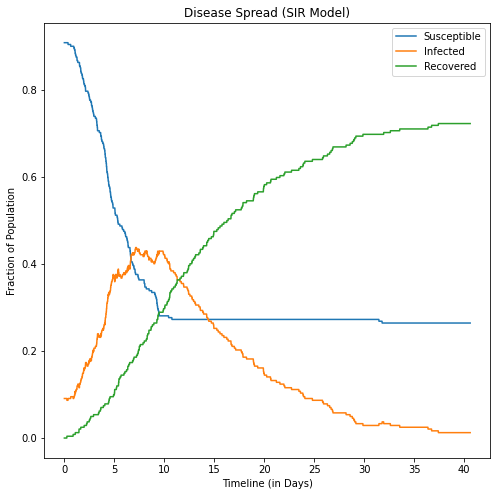

In [70]:
plot(X, Y, Z, t)

### Vaccination Strategy #1
Just vaccinate a fixed number of randomly picked unvaccinated people each time without any sort of testing. The recepient gains immunity only if he/she is susceptible.


In [77]:
X1, Y1, Z1, t = model.simulate(
    initial_infected_population=0.08,
    beta=1/100,
    gamma=1/1440,
    vac_strategy=1,
    vac_cap=4
)

0 day(s) have passed
X: 220, Y: 22, Z: 0
Vaccinations: 4, Quarantines: 0
1 day(s) have passed
X: 215, Y: 18, Z: 9
Vaccinations: 4, Quarantines: 0
2 day(s) have passed
X: 207, Y: 20, Z: 15
Vaccinations: 2, Quarantines: 0
3 day(s) have passed
X: 194, Y: 27, Z: 21
Vaccinations: 2, Quarantines: 0
4 day(s) have passed
X: 188, Y: 28, Z: 26
Vaccinations: 1, Quarantines: 0
5 day(s) have passed
X: 165, Y: 47, Z: 30
Vaccinations: 4, Quarantines: 0
6 day(s) have passed
X: 148, Y: 52, Z: 42
Vaccinations: 4, Quarantines: 0
7 day(s) have passed
X: 128, Y: 64, Z: 50
Vaccinations: 3, Quarantines: 0
8 day(s) have passed
X: 120, Y: 65, Z: 57
Vaccinations: 2, Quarantines: 0
9 day(s) have passed
X: 105, Y: 69, Z: 68
Vaccinations: 2, Quarantines: 0
10 day(s) have passed
X: 90, Y: 74, Z: 78
Vaccinations: 2, Quarantines: 0
11 day(s) have passed
X: 87, Y: 70, Z: 85
Vaccinations: 0, Quarantines: 0
12 day(s) have passed
X: 87, Y: 65, Z: 90
Vaccinations: 1, Quarantines: 0
13 day(s) have passed
X: 86, Y: 62, Z: 9

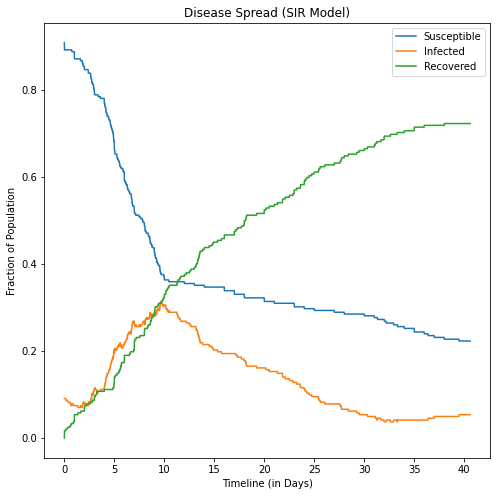

In [78]:
plot(X1, Y1, Z1, t)

### Vaccine Strategy #2
Before administartion of vaccine, the individual is to be tested. If found positive, they are quarantined. But, this will discourage people from getting vaccinated, therefore, to keep the results fair, the vaccination capacity must always be less than strategy #1 when comparing the two.

In [101]:
X2, Y2, Z2, t = model.simulate(
    initial_infected_population=0.08,
    beta=1/100,
    gamma=1/1440,
    vac_strategy=2,
    vac_cap=3
)

0 day(s) have passed
X: 220, Y: 22, Z: 0
Vaccinations: 3, Quarantines: 0
1 day(s) have passed
X: 216, Y: 23, Z: 3
Vaccinations: 3, Quarantines: 1
2 day(s) have passed
X: 197, Y: 36, Z: 9
Vaccinations: 3, Quarantines: 0
3 day(s) have passed
X: 175, Y: 52, Z: 15
Vaccinations: 3, Quarantines: 1
4 day(s) have passed
X: 161, Y: 58, Z: 23
Vaccinations: 3, Quarantines: 0
5 day(s) have passed
X: 135, Y: 77, Z: 30
Vaccinations: 2, Quarantines: 0
6 day(s) have passed
X: 114, Y: 95, Z: 33
Vaccinations: 3, Quarantines: 3
7 day(s) have passed
X: 98, Y: 95, Z: 49
Vaccinations: 2, Quarantines: 2
8 day(s) have passed
X: 87, Y: 92, Z: 63
Vaccinations: 1, Quarantines: 3
9 day(s) have passed
X: 80, Y: 80, Z: 82
Vaccinations: 1, Quarantines: 1
10 day(s) have passed
X: 65, Y: 88, Z: 89
Vaccinations: 2, Quarantines: 3
11 day(s) have passed
X: 60, Y: 83, Z: 99
Vaccinations: 0, Quarantines: 3
12 day(s) have passed
X: 60, Y: 74, Z: 108
Vaccinations: 0, Quarantines: 0
13 day(s) have passed
X: 60, Y: 68, Z: 114


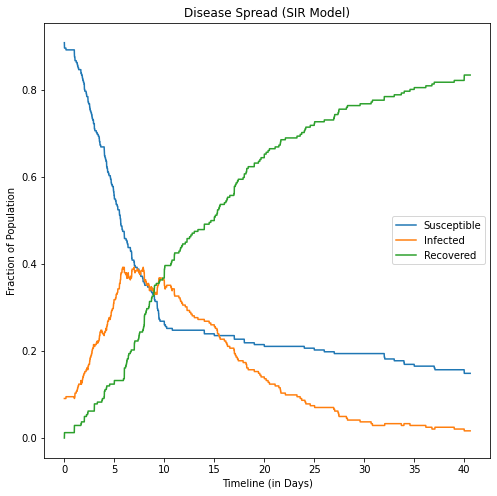

In [102]:
plot(X2, Y2, Z2, t)

## Results

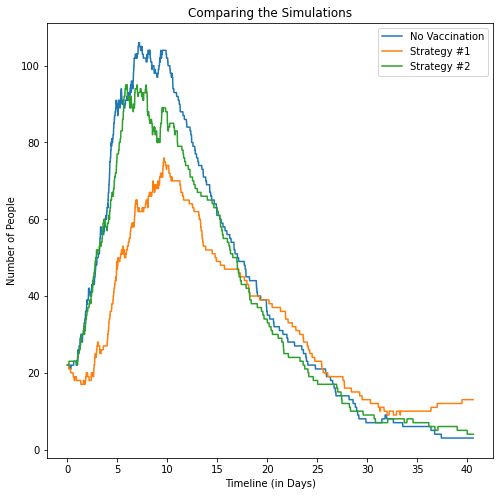

In [103]:
time = np.array(t) / (6 * 24)

plt.figure(figsize=(8, 8))
plt.plot(time, Y, label='No Vaccination')
plt.plot(time, Y1, label='Strategy #1')
plt.plot(time, Y2, label='Strategy #2')
plt.legend()
plt.title('Comparing the Simulations')
plt.xlabel('Timeline (in Days)')
plt.ylabel('Number of People')
plt.show()